# The Blood Transfusion Service Center Dataset

### Introduction 
Blood donation has been around for a long time. The first successful recorded transfusion was between two dogs in 1665, and the first medical use of human blood in a transfusion occurred in 1818. Even today, donated blood remains a critical resource during emergencies.

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive. 

### Problem Statement
We want to predict whether or not a donor will give blood the next time the vehicle comes to campus.

### Approach
As we are asked to provide the probability that a particular donor will donate blood (a binary variable), we use different types of binary classification models, models such as Logistic Regression, Random Forest and Gradient Boosting models including AdaBoost Classifier.

Lastly, to decide on which model to use in predicting the test dataset, we use the Logistic Loss, otherwise known as the Cross-Entropy loss as our evaluation metric. This is also the metric used by DrivenData to evaluate our predictions.

### Result
It turns out that the logistic model scored the best on the cross-validation dataset using the entropy loss metric. Using the simple logistic model, our entropy loss on the test dataset was 0.4440. This score was good enough to place us at rank 276 out of 3238 competitors (top 9th percentile).

## Importing key libraries and reading dataframes

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('Warm_Up_Predict_Blood_Donations_-_Traning_Data.csv')
df_test = pd.read_csv('Warm_Up_Predict_Blood_Donations_-_Test_Data.csv')

## Splitting into training and cross validation dataset

In [3]:
print(df_train.shape)
df_train.head()

(576, 6)


,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


It appears that the first column is the ID number. As the ID number doesn't contain any valuable information, we filter it out for our analysis.

In [4]:
from sklearn.model_selection import train_test_split

X = df_train.ix[:, 1:5]
y = df_train[['Made Donation in March 2007']]

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [5]:
df_test.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
0,659,2,12,3000,52
1,276,21,7,1750,38
2,263,4,1,250,4
3,303,11,11,2750,38
4,83,4,12,3000,34


In [6]:
X_test = df_test.ix[:, 1:5]

In [7]:
X_train = X_train.reset_index(drop = True)
X_cv = X_cv.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

## Exploratory Data Analysis

We first check for any missing values in the training and testing data.

In [8]:
X_train.isnull().sum()

Months since Last Donation     0
Number of Donations            0
Total Volume Donated (c.c.)    0
Months since First Donation    0
dtype: int64

In [9]:
X_cv.isnull().sum()

Months since Last Donation     0
Number of Donations            0
Total Volume Donated (c.c.)    0
Months since First Donation    0
dtype: int64

In [10]:
X_test.isnull().sum()

Months since Last Donation     0
Number of Donations            0
Total Volume Donated (c.c.)    0
Months since First Donation    0
dtype: int64

It turns out that the training, cross validation and testing dataset do not contain any NA values at all! That makes our data cleaning process much easier.

We now proceed to plot the distribution of the 4 different columns in the training data to get an idea of the data types that we are dealing with, as this can potentially help with our feature engineering.

In this case, the color, Red, represents Non-blood Donors, while the color, Blue, represents Donors.

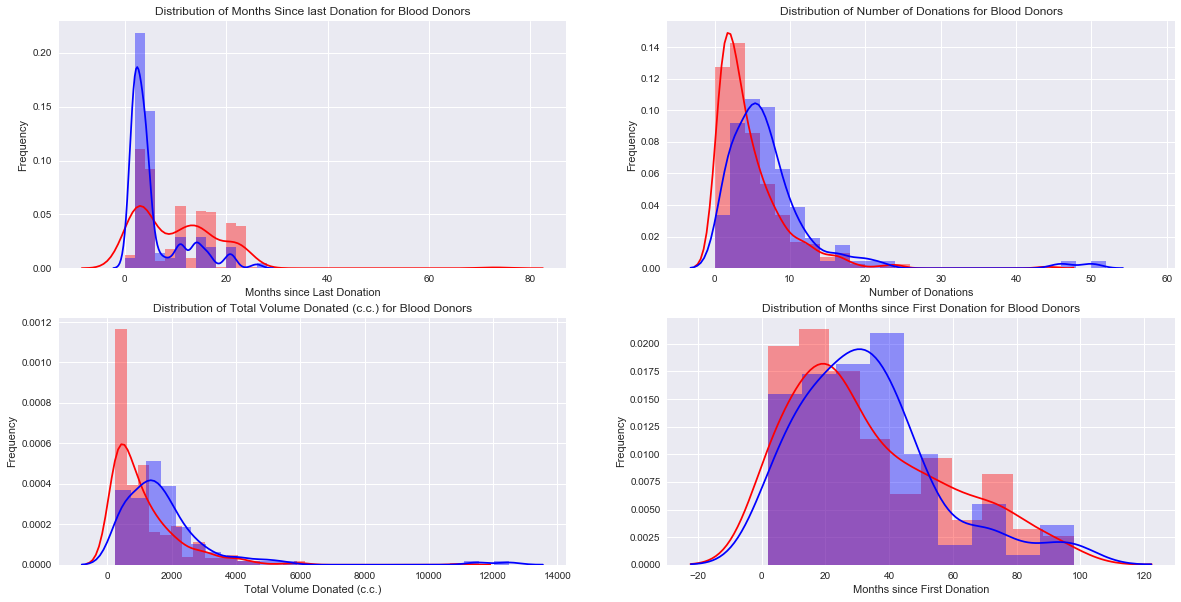

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20, 10))
plt.subplot(2, 2, 1)
sns.distplot(X_train[y_train.values == 0]['Months since Last Donation'], 
             bins = range(0, 81, 2), color = 'red')
plt.ylabel('Frequency')
plt.title('Distribution of Months Since last Donation for Non-blood Donors')

sns.distplot(X_train[y_train.values == 1]['Months since Last Donation'], 
             bins = range(0, 81, 2), color = 'blue')
plt.ylabel('Frequency')
plt.title('Distribution of Months Since last Donation for Blood Donors')

plt.subplot(2, 2, 2)
sns.distplot(X_train[y_train.values == 0]['Number of Donations'], 
             bins = range(0, 60, 2), color = 'red')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Donations for Non-blood Donors')

sns.distplot(X_train[y_train.values == 1]['Number of Donations'], 
             bins = range(0, 60, 2), color = 'blue')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Donations for Blood Donors')

plt.subplot(2, 2, 3)
sns.distplot(X_train[y_train.values == 0]['Total Volume Donated (c.c.)'], color = 'red')
plt.ylabel('Frequency')
plt.title('Distribution of Total Volume Donated (c.c.) for Non-blood Donors')

sns.distplot(X_train[y_train.values == 1]['Total Volume Donated (c.c.)'], color = 'blue')
plt.ylabel('Frequency')
plt.title('Distribution of Total Volume Donated (c.c.) for Blood Donors')

plt.subplot(2, 2, 4)
sns.distplot(X_train[y_train.values == 0]['Months since First Donation'], color = 'red')
plt.ylabel('Frequency')
plt.title('Distribution of Months since First Donation for Non-blood Donors')

sns.distplot(X_train[y_train.values == 1]['Months since First Donation'], color = 'blue')
plt.ylabel('Frequency')
plt.title('Distribution of Months since First Donation for Blood Donors')

plt.show()

Intuitively, blood donors who have frequently donated blood in the past are more likely to donate blood. In addition, donors who have donated within 3-6 months are much more likely to donate blood that their counterparts i.e. donors who have not donated in the past 6 months. 

On the other hand, the 'Months since First Donation' feature does not seem to be particularly informative of whether a blood donor donated blood in March 2007.

In addition, we note the presence of several outliers in the dataset.

We proceed to examine the relationship across the 4 features in the training dataset, by means of a pairsplot.

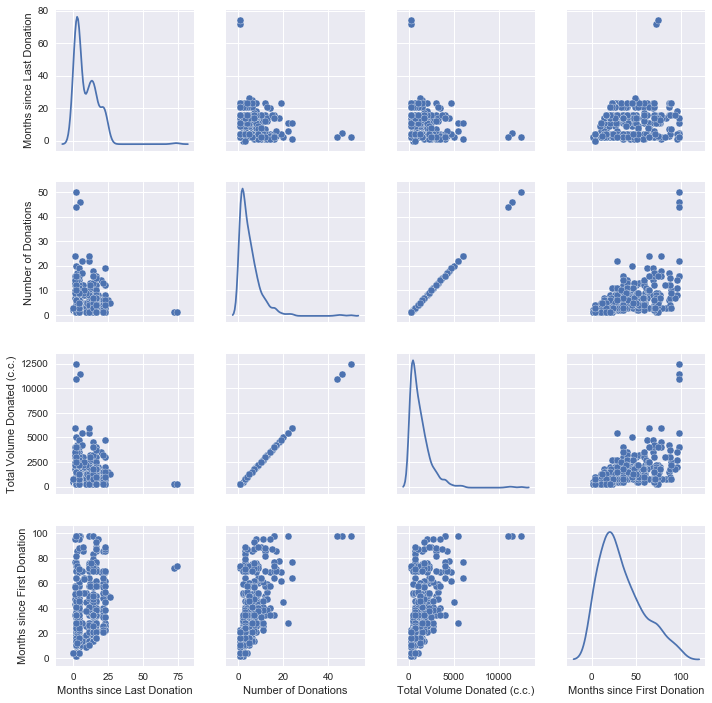

In [12]:
sns.pairplot(X_train, diag_kind='kde')
plt.show()

Both the feature distribution plots and the pairsplot seem to indicate that there are a few anomalies in the dataset. In addition, the pairsplot seem to suggest a linear relationship between the 2 variables, Total Number of Donations and Total Volume Donated. Could they be perfectly correlated?

We check this phenomena using the correlation between these features, by means of a heatmap.

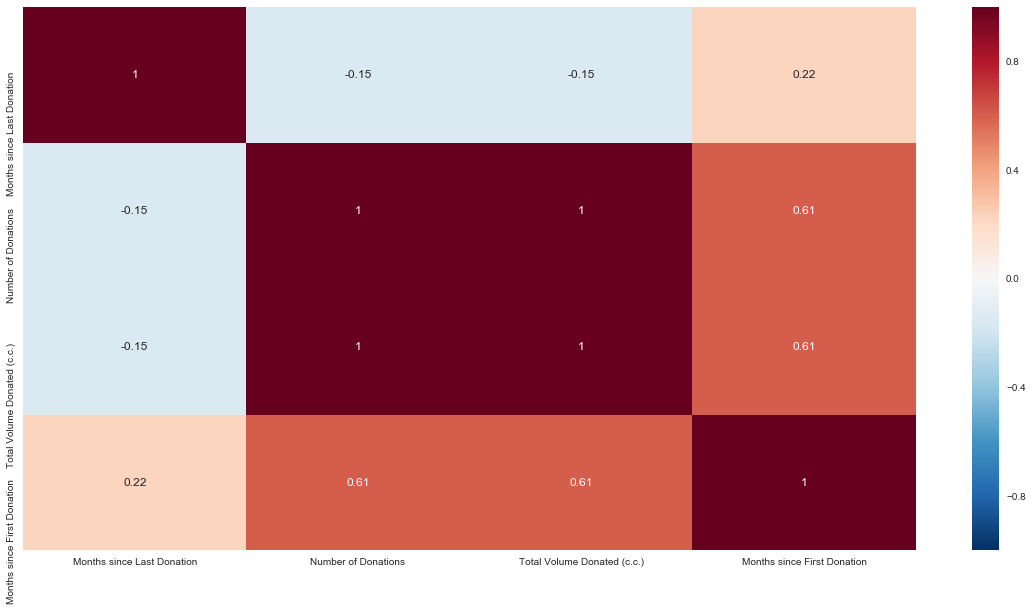

In [13]:
plt.figure(figsize = (20, 10))
X_train_corr = X_train.corr()

sns.heatmap(X_train_corr, annot = True)
plt.show()

This confirms our suspicion that the features, Number of Donations and Total Volume Donated, are indeed perfectly correlated. Looking back, this shouldn't be very surprising, as donors typically donate a certain amount of blood for each visit. (In this case, the amount is 250 c.c., or 250 ml if you will)

In addition, we note that that there exists a weak positive correlation between Number of Donations (same for Total Volume Donated) and Months since First Donation. This is likely due to the presence of anomalies present in our training dataset.

Lastly, we take a quick look at the unique values that our label can take on.

In [14]:
print set(y_train['Made Donation in March 2007'])
print set(y_cv['Made Donation in March 2007'])

set([0, 1])
set([0, 1])


As there are only 2 values: 0 and 1, this suggests that we do not have to conduct data cleaning for the label variable.

### Feature Engineering and Feature Selection

As some of our features are perfectly correlated with one another, including all these features do not provide any additional information as compared to only including 1 of these features. This means that we should remove one of the features which are perfectly correlated with the other feature.

But before we do so, we could generate additional features using existing ones. For example, one of the many features we might be interested in is the average donation of each donor.

In [15]:
X_train['Average Donation per Month'] = (X_train['Total Volume Donated (c.c.)']/
                                         X_train['Months since First Donation'])

In [16]:
X_train.head()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Average Donation per Month
0,4,4,1000,18,55.555556
1,2,1,250,2,125.000000
2,20,14,3500,69,50.724638
3,2,2,500,11,45.454545
4,11,4,1000,58,17.241379


We do the same for the cross validation dataset and the testing dataset.

In [17]:
X_cv['Average Donation per Month'] = X_cv['Total Volume Donated (c.c.)']/X_cv['Months since First Donation']
X_test['Average Donation per Month'] = X_test['Total Volume Donated (c.c.)']/X_test['Months since First Donation']

Is our new indicator a good predictor for whether the donor donated blood in March 2007?

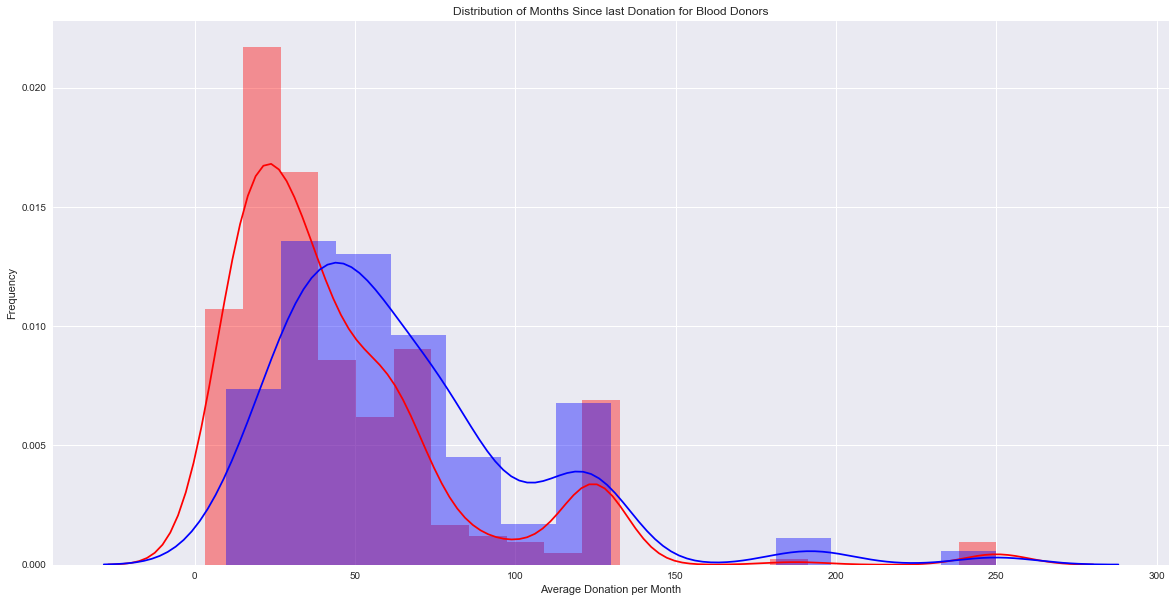

In [18]:
plt.figure(figsize = (20, 10))

sns.distplot(X_train[y_train.values == 0]['Average Donation per Month'], color = 'red')
plt.ylabel('Frequency')
plt.title('Distribution of Months Since last Donation for Non-blood Donors')

sns.distplot(X_train[y_train.values == 1]['Average Donation per Month'], color = 'blue')
plt.ylabel('Frequency')
plt.title('Distribution of Months Since last Donation for Blood Donors')

plt.show()

From the plot, it does appear that donors who, on average, donate more than 50 ml of blood per month are more likely to donate blood.

We include a new variable, average waiting length for donation, to observe the frequency which the donor donates blood.

In [19]:
X_train['Waiting Time'] = ((X_train['Months since First Donation'] - X_train['Months since Last Donation'])
                           /X_train['Number of Donations'])

X_cv['Waiting Time'] = ((X_cv['Months since First Donation'] - X_cv['Months since Last Donation'])
                        /X_cv['Number of Donations'])

X_test['Waiting Time'] = ((X_test['Months since First Donation'] - X_test['Months since Last Donation'])
                          /X_test['Number of Donations'])

Is this additional feature informative of whether a donor is likely to donate blood in March 2007? Let's find out.

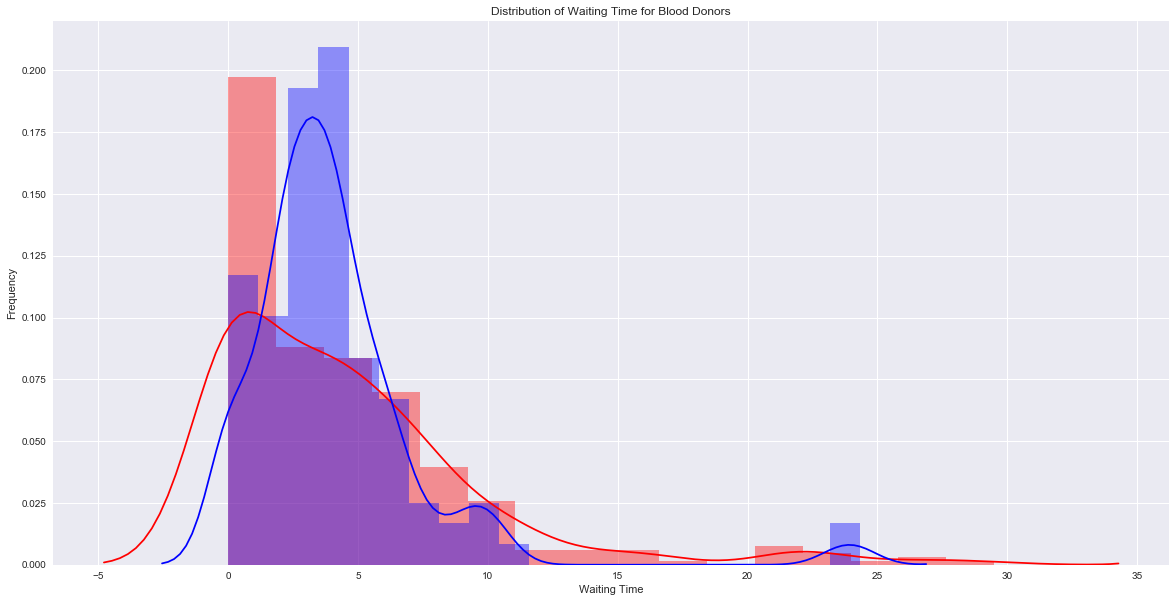

In [20]:
plt.figure(figsize = (20, 10))

sns.distplot(X_train[y_train.values == 0]['Waiting Time'], color = 'red')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Time for Non-blood Donors')

sns.distplot(X_train[y_train.values == 1]['Waiting Time'], color = 'blue')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Time for Blood Donors')

plt.show()

As it turns out, frequent donors are much more likely to donate blood than their counterparts. However, one thing stands out - donors with Waiting Time of less than 2 months are much more likely to donated blood than their counterpart - why? I think this is due to the fact that there are quite a few one-time donors in the dataset. For one-time donors, waiting time is essentially 0, as they do not donate blood after their first time.

This begs the question: Are one-time donors more likely to donate blood than their counterparts? What if we controlled for the feature, 'Months since First Donation'?

In [21]:
X_train['One-time Donor'] = map(int, (X_train['Number of Donations'] == 1))
tab = pd.crosstab(X_train['One-time Donor'], y_train['Made Donation in March 2007'])

tab.div(tab.sum(1).astype(float), axis=0)

Made Donation in March 2007,0.0,1.0
One-time Donor,,
0.0,0.735593,0.264407
1.0,0.753247,0.246753


As it turns out, One-time Donors are not more likely (or unlikely) to donate blood than their counterparts.

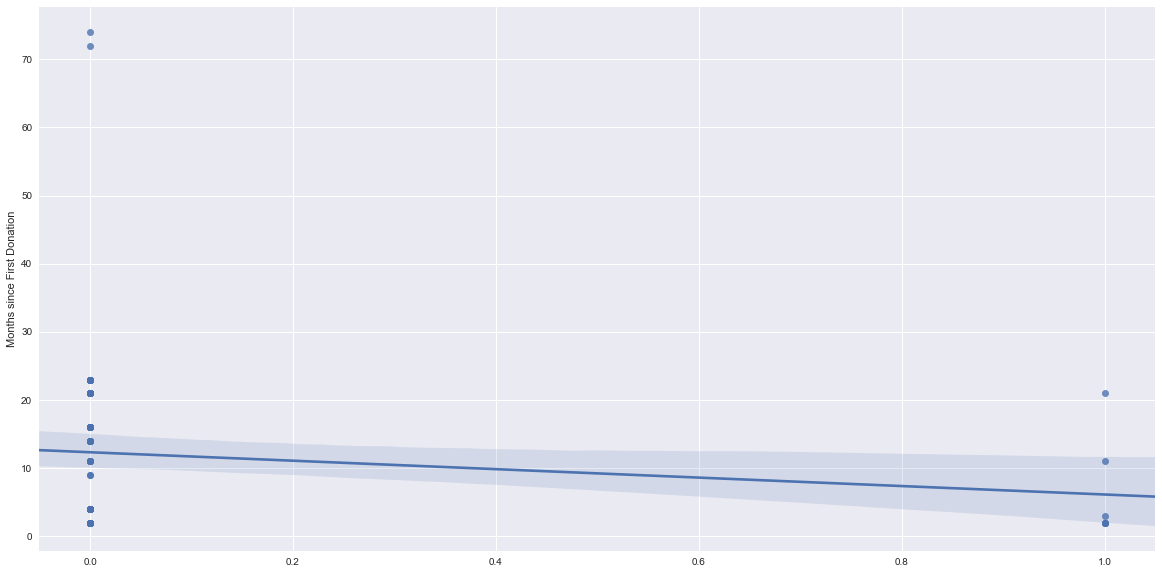

In [22]:
plt.figure(figsize = (20, 10))
sns.regplot(x = y_train.reset_index(drop = True)[X_train['One-time Donor'] == 1],
            y = X_train[X_train['One-time Donor'] == 1]['Months since First Donation']) 

plt.show()

However, it turns out that after controlling for the 'Months since First Donation', there appears to an asymmetric effect of the One-time Donor on whether the Blood Donor donated blood in March 2007, albeit a slight one.

As the effect does not appear to be statistically significant (and even if it is, it is likely to be weak), we do not include this variable in our dataset.

In [23]:
del X_train['One-time Donor']

From the plots above, we figured that donors who donated 3-6 months prior and donors who have donated more than 5 times ever since their first donation are much more likely to donate blood than their peers. Let's create new features based on this set of information.

In addition, it is important to note that donors who donated 3 months prior are not much likely to donate blood than their counterparts. As a result, the feature should not include these donors.

In [24]:
X_train['Donated in the past 3-6 months'] = ((X_train['Months since Last Donation'] >= 3) &
                                             (X_train['Months since Last Donation'] <= 6))

X_cv['Donated in the past 3-6 months'] = ((X_cv['Months since Last Donation'] >= 3) &
                                          (X_cv['Months since Last Donation'] <= 6))

X_test['Donated in the past 3-6 months'] = ((X_test['Months since Last Donation'] >= 3) &
                                            (X_test['Months since Last Donation'] <= 6))

In [25]:
X_train['Frequent Donor'] = (X_train['Number of Donations'] >= 5)

X_cv['Frequent Donor'] = (X_cv['Number of Donations'] >= 5)

X_test['Frequent Donor'] = (X_test['Number of Donations'] >= 5)

Next, we proceed to remove the Total Volume Donated (c.c.) feature from the 3 datasets.

In [26]:
cols_to_keep = ['Months since Last Donation', 'Number of Donations',
                'Months since First Donation', 'Average Donation per Month', 
                'Waiting Time', 'Donated in the past 3-6 months', 'Frequent Donor']
X_train = X_train[cols_to_keep]; X_cv = X_cv[cols_to_keep]; X_test = X_test[cols_to_keep]

In [27]:
X_train.head()

,Months since Last Donation,Number of Donations,Months since First Donation,Average Donation per Month,Waiting Time,Donated in the past 3-6 months,Frequent Donor
0,4,4,18,55.555556,3.50,True,False
1,2,1,2,125.000000,0.00,False,False
2,20,14,69,50.724638,3.50,False,True
3,2,2,11,45.454545,4.50,False,False
4,11,4,58,17.241379,11.75,False,False


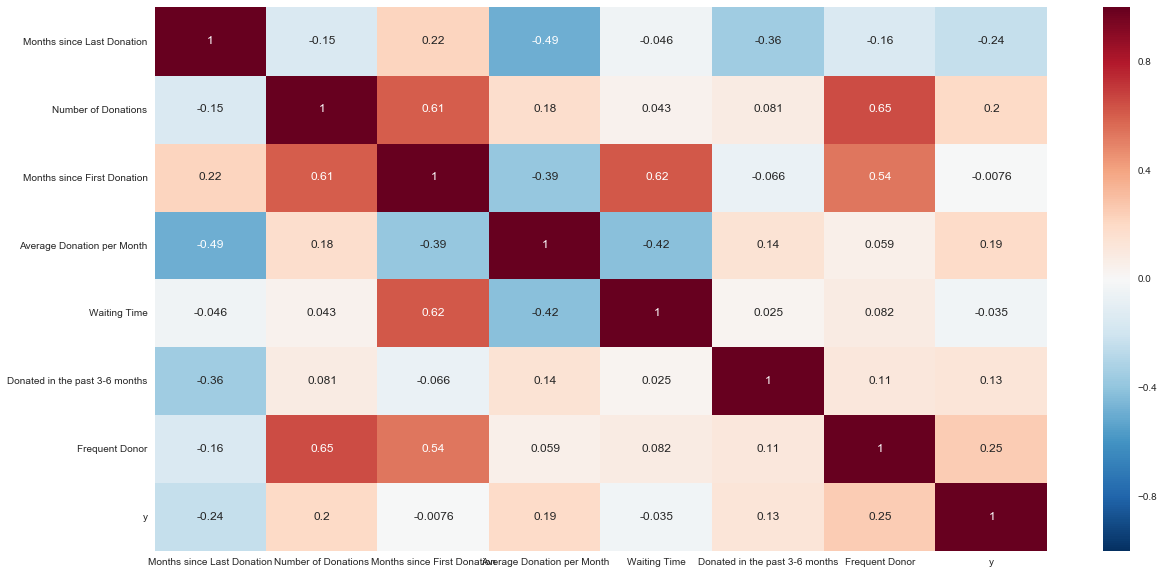

In [28]:
plt.figure(figsize = (20, 10))
train_ = X_train.copy(); train_['y'] = y_train.reset_index(drop = True)
train_corr = train_.corr()

sns.heatmap(train_corr, annot = True)
plt.show()

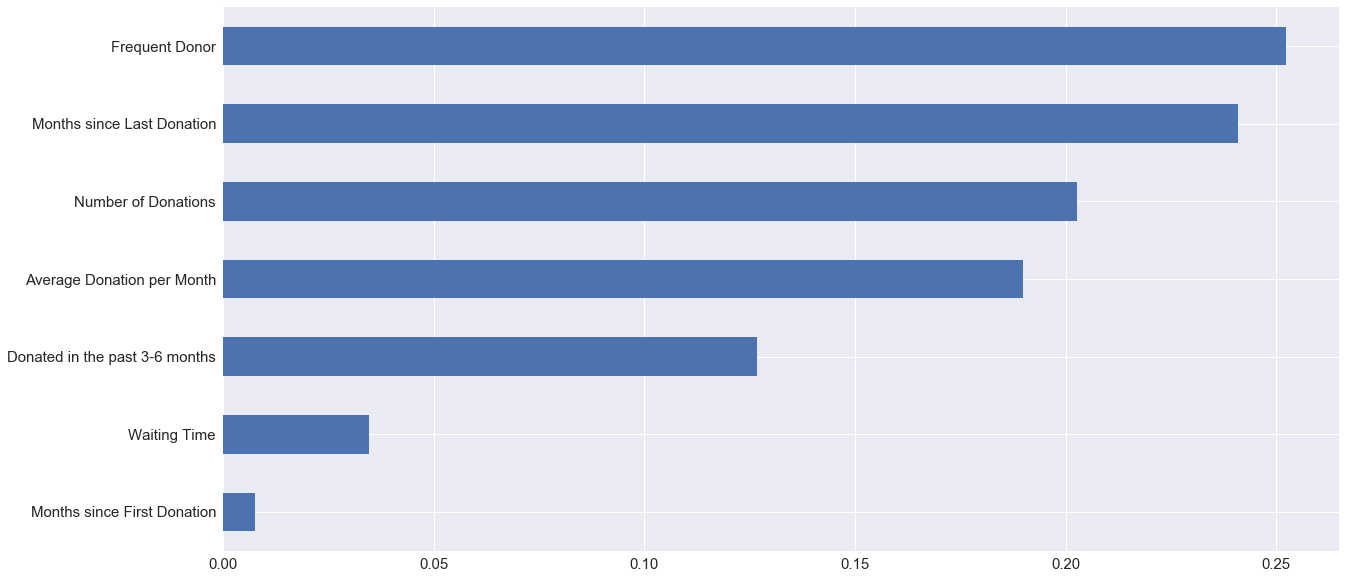

In [29]:
plt.figure(figsize = (20, 10))
sns.set(font_scale = 1.5)
(abs(train_corr)
 .y
 .drop('y')
 .sort_values()
 .plot
 .barh())
plt.show()

Now that we are armed with our features, let's fit some models!

### Model Fitting

Noting that we are asked to predict the probability of the donor donating blood, we fit 3 different kinds of models - Logistic Regression, Random Forest and Gradient Boosting (AdaBoost).

We can import these models from the scikit-learn library, using the following code: 
```python
from sklearn.linear_model import LogisticRegressionCV # Logistic Regression
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.ensemble import AdaBoostClassifier # Gradient Boosting (AdaBoost)
from sklearn.svm import SVM # Support Vector Machine
``` 

In addition, we conduct hyperparameter and optimizer tuning to search for the best models across each class. We can implement this using:
```python
from sklearn.model_selection import GridSearchCV
```

But before we fit these models, we conduct feature normalization on our dataset. For numeric feeatures, we conduct feature scaling using the StandardScaler. For factor variables, we use Scikit-learn's LabelEncoder.

In [30]:
from sklearn.preprocessing import StandardScaler

numericFeatures = ['Months since Last Donation', 'Number of Donations', 
                   'Average Donation per Month', 'Waiting Time', 'Months since First Donation']
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numericFeatures]))
X_cv_scaled = pd.DataFrame(scaler.transform(X_cv[numericFeatures]))
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numericFeatures]))

In [31]:
from sklearn.preprocessing import LabelEncoder

factorVar = ['Frequent Donor', 'Donated in the past 3-6 months']

le = LabelEncoder()

for i in factorVar:
    X_train_scaled[i] = le.fit_transform(X_train[i])
    X_cv_scaled[i] = le.transform(X_cv[i])
    X_test_scaled[i] = le.transform(X_test[i])

Next, we can fit the 4 different kinds of binary classification models, with hyperparameter tuning:

* Logistic Regression Classifier
* Random Forest Classifier
* AdaBoosting Classifier
* Support Vector Machine

In [32]:
# Model 1 - Logistic Regression
from sklearn.linear_model import LogisticRegressionCV

logregr = LogisticRegressionCV(cv = 5, random_state=12, scoring ='neg_log_loss')
logregr = logregr.fit(X_train_scaled, y_train['Made Donation in March 2007'])

y_cv_logregr = logregr.predict_proba(X_cv_scaled)[:, 1]

In [33]:
# Model 2 - RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

randomforest = RandomForestClassifier(random_state = 10)
param_grid = {'n_estimators': [50, 100, 150],
              'max_features': [1, 2, 3]}
rf = GridSearchCV(estimator = randomforest, param_grid = param_grid, cv = 5,
                  scoring = 'neg_log_loss')
rf.fit(X_train_scaled, y_train['Made Donation in March 2007'])

y_cv_rf = rf.predict_proba(X_cv_scaled)[:, 1]

In [34]:
# Model 3 - AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

abc = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1),
                         random_state = 10)
param_grid = {'n_estimators': [50, 100, 150],
              'algorithm': ['SAMME', 'SAMME.R']}
abc = GridSearchCV(abc, param_grid = param_grid, cv = 5,
                   scoring = 'neg_log_loss')

abc.fit(X_train_scaled, y_train['Made Donation in March 2007'])

y_cv_abc = abc.predict_proba(X_cv_scaled)[:, 1]

In [35]:
# Model 4 - Support Vector Machine
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC(probability = True)
param_grid = {'kernel': ['rbf', 'linear'],
              'gamma': np.logspace(-4, 1, 10),
              'random_state': [10]}
svm = GridSearchCV(svm, param_grid = param_grid, cv = 5,
                   scoring = 'neg_log_loss')

svm.fit(X_train_scaled, y_train['Made Donation in March 2007'])

y_cv_svm = svm.predict_proba(X_cv_scaled)[:, 1]

We will use the evaluation metric, entropy loss (or logistic loss) as our evaluation metric. We can import the relevant function from the scikit-learn library:
```python
from sklearn.metrics import log_loss
```

In [36]:
from sklearn.metrics import log_loss

# Logistic Regression
print 'Logistic Regression - Entropy Loss: ', log_loss(y_cv, y_cv_logregr)

# Random Forest
print 'Random Forest - Entropy Loss: ', log_loss(y_cv, y_cv_rf)

# AdaBoost
print 'Gradient Boosting - Entropy Loss: ', log_loss(y_cv, y_cv_abc)

# Support Vector Machine
print 'Support Vector Machine - Entropy Loss: ', log_loss(y_cv, y_cv_svm)

Logistic Regression - Entropy Loss:  0.53945810197
Random Forest - Entropy Loss:  1.73312532683
Gradient Boosting - Entropy Loss:  0.65165351356
Support Vector Machine - Entropy Loss:  0.58139788305


As it turns out, the Logistic Regression has the lowest entropy loss (lower is better, in this case). We use the simple logistic model to conduct predictions for our test set.

### Prediction
We combine the training and test set and estimate the Logistic Regression Model using the hyperparameters found previously.

Let's take a quick look at the hyperparameters we have found previously.

In [37]:
logregr

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=12,
           refit=True, scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
           verbose=0)

The optimal hyperparameter values found using LogisticRegressionCV will be used in our final model. In this case, the regularization parameter, C, will be set to 10.

In [38]:
X_total = pd.concat([pd.DataFrame(X_train_scaled), pd.DataFrame(X_cv_scaled)])
y_total = pd.concat([y_train, y_cv]).values

final_model = logregr.fit(X_total, y_total)
y_test = final_model.predict_proba(X_test_scaled)[:, 1]

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


As a sense check, we check if our predicted probabilities are largely in line with the mean proportion of donors which donated blood.

In [39]:
print y_test.mean(), df_train['Made Donation in March 2007'].values.mean()

0.239048205526 0.239583333333


It turns out that the values are not very different from one another. Let's submit our predictions!

In [40]:
submission = pd.read_csv('Warm_Up_Predict_Blood_Donations_-_Submission_Format.csv', index_col = 0)
submission['Made Donation in March 2007'] = y_test

In [41]:
submission.to_csv('test_submission.csv')

Afternote: 

Using our simple logistic model, the entropy loss which we obtained on our testset was 0.4440. 

This score was good enough to place us at rank 276 out of 3238 competitors (top 9th percentile).